## Spark Machine Learning

Entrenaremos un modelo de clasificación binaria, para tratar de predecir si los costes médicos de una persona serán superiores a 50,000 dólares o no.

Se muestrarn las algunas capacidades disponibles en MLlib, incluidas herramientas para el procesamiento de datos, canalizaciones de aprendizaje automático y varios algoritmos de aprendizaje automático diferentes.

## Modelo de clasificación.

1. Carga de conjunto de datos.
2. Preprocesamiento de funciones.
3. Definición del modelo.
4. Construcción de canalización.
5. Evaluación del modeo.
6. Ajuste de hiperparametros.
7. Predicciones con nuevos datos.

#### Antes de comenzar una Introducción al paquete MLlib, veamos los componentes, flujo de trabajo e ingeniería de características con MLlib.

**Machine Learning :** es la construcción de algoritmos que pueden aprender de los datos y hacer predicciones sobre ellos.

**Spark MLlib :** se usa para realizar aprendizaje automático en Apache Spark. MLlib consta de algoritmos y funciones habituales.


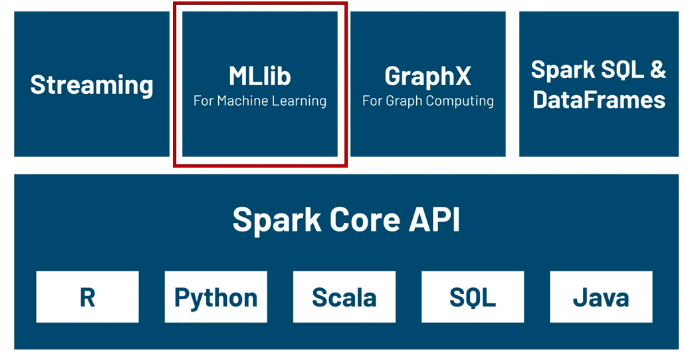

In [1]:
from IPython import display
display.Image("Images/MLlib1.png")

Herramientas de MLlib :

**spark.mllib** contiene la API original construida sobre RDD.

**spark.ml** proporciona una API de nivel superior construida sobre DataFrames para construcción de pipelines de ML. La API de ML principal.

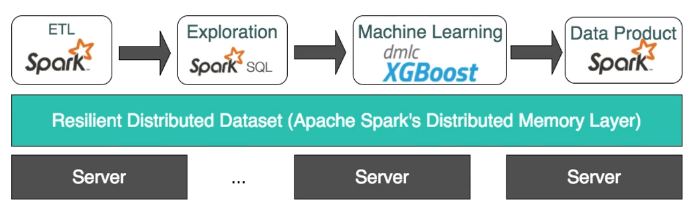

In [2]:
display.Image("Images/MLlib2.png")

## Componentes Spark Machine Learning.


**Spark MLlib** proporciona las siguientes herramientas:

**Algoritmos ML :** Incluye algoritmos de aprendizar comunes como clasificación, regresión, agrupamiento y filtrado colaborativo.

**Carecterización :** Extracción, transformación, reducción de dimensionalidad y selección de características.

**Pipelines :** Son herramientas para construir modelos de ML en etapas.

**Persistencia :** Permite guardar y cargar algoritmos, modelos y pipelines.

**Utilidades :** Para álgebra lineal, estadística y manejo de datos.

**Documentación :** https://spark.apache.org/docs/latest/ml-guide.html

## Proceso de Machine Learning.



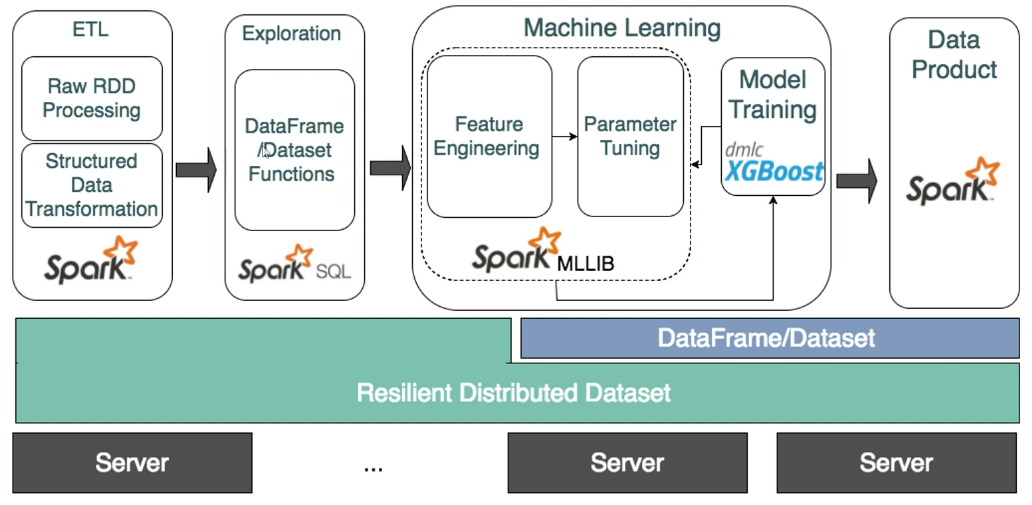

In [3]:
display.Image("Images/MLlib3.png")

### Ingeniería de características con Spark.

* **Vector Assembler** : Se utiliza básicamente para concatenar todas las características en un solo vector que se puede pasar al estimador o al algoritmo ML. **Se utiliza siempre en todos los modelos de MLlib**

* **Agrupamiento** : Método más sencillo para convertir las variables continuas en variables categóricas. Se puede realizar con la clase $Bucketizer$.

* **Escalado y normalización** : Tarea común en variables continuas. Permite que los datos tengan una $distribución normal$.

* **MinMaxScaler y StandarScaler** : Estandarizan las características con una media cero y una desviación estándar de 1.

* **StringIndexer** : Convierte características categóricas en numéricas. 

Imagen de ejemplo de un Vector Assembler.

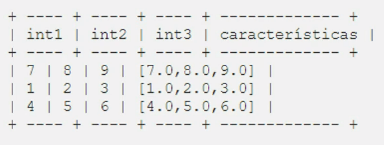

In [4]:
display.Image("Images/MLlib4.png")

## 1. Carga de conjunto de datos.

In [83]:
import findspark
findspark.init()

from pyspark.sql import SparkSession
from pyspark.sql.functions import *
from pyspark.sql.functions import broadcast
from pyspark.sql.types import *

spark = SparkSession.builder.getOrCreate()

In [84]:
schema = """`age` DOUBLE,
`workclass` STRING,
`fnlwgt` DOUBLE,
`education` STRING,
`education_num` DOUBLE,
`marital_status` STRING,
`occupation` STRING,
`relationship` STRING,
`race` STRING,
`sex` STRING,
`capital_gain` DOUBLE,
`capital_loss` DOUBLE,
`hours_per_week` DOUBLE,
`navite_country` STRING,
`income` STRING"""

dataset = spark.read.csv("Datos/adult.data", schema = schema)
dataset.show(10)

+----+-----------------+--------+----------+-------------+--------------------+------------------+--------------+------+-------+------------+------------+--------------+--------------+------+
| age|        workclass|  fnlwgt| education|education_num|      marital_status|        occupation|  relationship|  race|    sex|capital_gain|capital_loss|hours_per_week|navite_country|income|
+----+-----------------+--------+----------+-------------+--------------------+------------------+--------------+------+-------+------------+------------+--------------+--------------+------+
|39.0|        State-gov| 77516.0| Bachelors|         13.0|       Never-married|      Adm-clerical| Not-in-family| White|   Male|      2174.0|         0.0|          40.0| United-States| <=50K|
|50.0| Self-emp-not-inc| 83311.0| Bachelors|         13.0|  Married-civ-spouse|   Exec-managerial|       Husband| White|   Male|         0.0|         0.0|          13.0| United-States| <=50K|
|38.0|          Private|215646.0|   HS-g

**Exploración de los datos**

In [89]:
dataset.count()

32561

Variables categorícas, no contamos con valores nulos. Los datos tienen buena completitud.

In [91]:
categoricalCols = ["workclass", "education", "marital_status", "occupation", "relationship", "race", "sex"]

dataset.select(categoricalCols).describe().show()

+-------+------------+-------------+--------------+-----------------+------------+-------------------+-------+
|summary|   workclass|    education|marital_status|       occupation|relationship|               race|    sex|
+-------+------------+-------------+--------------+-----------------+------------+-------------------+-------+
|  count|       32561|        32561|         32561|            32561|       32561|              32561|  32561|
|   mean|        null|         null|          null|             null|        null|               null|   null|
| stddev|        null|         null|          null|             null|        null|               null|   null|
|    min|           ?|         10th|      Divorced|                ?|     Husband| Amer-Indian-Eskimo| Female|
|    max| Without-pay| Some-college|       Widowed| Transport-moving|        Wife|              White|   Male|
+-------+------------+-------------+--------------+-----------------+------------+-------------------+-------+



No contamos con valores nulls, tienen buena completitud. Veamos los valores promedio, mínimos, máximos.

In [93]:
numericCols = ["age", "fnlwgt", "education_num", "capital_gain", "capital_loss", "hours_per_week"]

dataset.select(numericCols).describe().show()

+-------+------------------+------------------+-----------------+------------------+----------------+------------------+
|summary|               age|            fnlwgt|    education_num|      capital_gain|    capital_loss|    hours_per_week|
+-------+------------------+------------------+-----------------+------------------+----------------+------------------+
|  count|             32561|             32561|            32561|             32561|           32561|             32561|
|   mean| 38.58164675532078|189778.36651208502| 10.0806793403151|1077.6488437087312| 87.303829734959|40.437455852092995|
| stddev|13.640432553581356|105549.97769702227|2.572720332067397| 7385.292084840354|402.960218649002|12.347428681731838|
|    min|              17.0|           12285.0|              1.0|               0.0|             0.0|               1.0|
|    max|              90.0|         1484705.0|             16.0|           99999.0|          4356.0|              99.0|
+-------+------------------+----

Cantidad de registros por país. United-States predomina en la muestra.

In [103]:
dataset.groupby("navite_country").count().orderBy(desc("count")).show()

+-------------------+-----+
|     navite_country|count|
+-------------------+-----+
|      United-States|29170|
|             Mexico|  643|
|                  ?|  583|
|        Philippines|  198|
|            Germany|  137|
|             Canada|  121|
|        Puerto-Rico|  114|
|        El-Salvador|  106|
|              India|  100|
|               Cuba|   95|
|            England|   90|
|            Jamaica|   81|
|              South|   80|
|              China|   75|
|              Italy|   73|
| Dominican-Republic|   70|
|            Vietnam|   67|
|          Guatemala|   64|
|              Japan|   62|
|             Poland|   60|
+-------------------+-----+
only showing top 20 rows



In [104]:
dataset.groupBy("education").count().sort("count", ascending = False).show()

+-------------+-----+
|    education|count|
+-------------+-----+
|      HS-grad|10501|
| Some-college| 7291|
|    Bachelors| 5355|
|      Masters| 1723|
|    Assoc-voc| 1382|
|         11th| 1175|
|   Assoc-acdm| 1067|
|         10th|  933|
|      7th-8th|  646|
|  Prof-school|  576|
|          9th|  514|
|         12th|  433|
|    Doctorate|  413|
|      5th-6th|  333|
|      1st-4th|  168|
|    Preschool|   51|
+-------------+-----+



**Datos de entrenamiento y Test.**

In [105]:
trainDF, testDF = dataset.randomSplit([0.8, 0.2], seed = 42)
print(trainDF.cache().count())
print(testDF.count())

26076
6485


### Transformadores, estimadores y tuberías.

Tres conceptos importantes en el aprendizaje automático de MLlib que se ilustran en este notebook son Transformers, estimadores y Pipelines.

* **Transformadores :** Toma un data frame como entrada y devuelve un nuevo data frame. Los transformadores no aprenden ningún parámetro de los datos y simplemente aplican las transformaciones basadas en reglas para preparar los datos para el entrenamiento del modelo o generar predicciones usando un modeo de MLlib entrenado. Llamas a un transformador con un método $transform()$

* **Estimador :** Aprende los parámetros del DataFrame a través de un método $.fit()$ y devuelve un modelo, que es un transformador.

* **Pipeline :** Combina varios pasos en un solo flujo de trabajo que se puede ejecutar fácilmente. La creación de un modelo de aprendizaje automático generalmente implica configurar muchos pasos diferentes e iterar sobre ellos. Los pipelines ayudan a automatizar este proceso.

## Paso 2. Preprocesamiento de funciones (Preprocesamiento de características).

El objetivo de este cuaderno es construir un modelo que prediga el nivel de "ingresos" a partir de las características incluidas en el conjunto de datos (nivel de educación, estado civil, ocupación, etc.) El primer paso es manipular, o preprocesar, las características para que estén en el formato que requere MLlib.

### Convertir variables categóricas en numéricas.

Algunos algoritmos de aprendizaje automático, como la regresión lineal y logística, requieren funciones numéricas. El conjunto de datos incluye características categóricas como educación, ocupación y estado civil.

El siguiente bloque de código ilustra cómo usar $StringIndexer$ y $OneHotEnconder$ para convertir variables categóricas en un conjunto de variables numéricas que solo toman los valores 0 y 1.

* $StringIndexer$ convierte una columna de valores de cadena en una columna de índices de etiquetas. Por ejemplo, podría convertir los valores "rojo", "azul" y "verde" en 0,1 y 2.

* $OneHotEncoder$ mepae una columna de índices de categoría a una columna de vectores binarios, con como máximo un "1" en cada fila que indica el índice de categoría para esa fila.

La codificación one-hot en Spark es un proceso de 2 pasos. Primero usa StringIndexer seguido de OneHotEncoder. El siguiente bloque de código define StringIndexer y OneHotEncoder pero aún no lo aplica a ningún dato.


In [42]:
dataset.printSchema()

root
 |-- age: double (nullable = true)
 |-- workclass: string (nullable = true)
 |-- fnlwgt: double (nullable = true)
 |-- education: string (nullable = true)
 |-- education_num: double (nullable = true)
 |-- marital_status: string (nullable = true)
 |-- occupation: string (nullable = true)
 |-- relationship: string (nullable = true)
 |-- race: string (nullable = true)
 |-- sex: string (nullable = true)
 |-- capital_gain: double (nullable = true)
 |-- capital_loss: double (nullable = true)
 |-- hours_per_week: double (nullable = true)
 |-- navite_country: string (nullable = true)
 |-- income: string (nullable = true)



In [64]:
from pyspark.ml.feature import StringIndexer, OneHotEncoder

categoricalCols = ["workclass", "education", "marital_status", "occupation", "relationship", "race", "sex"]

stringIndexer = StringIndexer(inputCols = categoricalCols, outputCols = [x + "Index" for x in categoricalCols])
encoder = OneHotEncoder(inputCols = stringIndexer.getOutputCols(), outputCols = [x + "OHE" for x in categoricalCols])

labelToIndex = StringIndexer(inputCol = "income", outputCol = "label")

labelToIndex

StringIndexer_b1c41e575157

In [45]:
stringIndexer.getOutputCols()

['workclassIndex',
 'educationIndex',
 'marital_statusIndex',
 'occupationIndex',
 'relationshipIndex',
 'raceIndex',
 'sexIndex']

In [44]:
encoder.getOutputCols()

['workclassOHE',
 'educationOHE',
 'marital_statusOHE',
 'occupationOHE',
 'relationshipOHE',
 'raceOHE',
 'sexOHE']

In [106]:
stringIndexerModel = stringIndexer.fit(trainDF)
stringIndexerModel.transform(trainDF).show(10)

+----+---------+--------+---------+-------------+--------------+----------+---------------+------+-------+------------+------------+--------------+--------------+------+--------------+---------+---------------+-----------------+--------------+-------------------+--------+
| age|workclass|  fnlwgt|education|education_num|marital_status|occupation|   relationship|  race|    sex|capital_gain|capital_loss|hours_per_week|navite_country|income|educationIndex|raceIndex|occupationIndex|relationshipIndex|workclassIndex|marital_statusIndex|sexIndex|
+----+---------+--------+---------+-------------+--------------+----------+---------------+------+-------+------------+------------+--------------+--------------+------+--------------+---------+---------------+-----------------+--------------+-------------------+--------+
|17.0|        ?| 34019.0|     10th|          6.0| Never-married|         ?|      Own-child| White|   Male|         0.0|         0.0|          20.0| United-States| <=50K|           7

### Combina todas las columnas de características en un solo vector de características.

La mayoría de los algoritmos MLlib requiere una sola columna de características como entrada. Cada fila de esta columna contiene un vector de puntos de datos correspondientes al conjunto de características utilizadas para la predicción. 

MLlib proporciona el transformador $Vector Assembler$ para crear una única columna vectorial a partir de una lista de columnas.


In [67]:
from pyspark.ml.feature import VectorAssembler

numericCols = ["age", "fnlwgt", "education_num", "capital_gain", "capital_loss", "hours_per_week"]
assemblerInputs = [c + "OHE" for c in categoricalCols] + numericCols
vecAssembler = VectorAssembler(inputCols = assemblerInputs, outputCol = "features")

vecAssembler.setOutputCol

<bound method VectorAssembler.setOutputCol of VectorAssembler_10b68939e6d1>

## Paso 3. Definición del modelo.

Utilizaremos el modelo de regresión lógistica.

In [62]:
from pyspark.ml.classification import LogisticRegression

lr = LogisticRegression(featuresCol="features", labelCol="label", regParam=1.0)

lr

LogisticRegression_af050ef9a7e4

## Paso 4. Construye la canalización.

Un Pipeline es una lista ordenada de transformadores y estimadores. Puede definir una canalización para automatizar y garantizar la repetiblidad de las transformaciones que se aplicarán a un conjunto de datos. 

En este paso, definimos la canalización y luego la aplicamos al conjunto de datos de prueba.

Similar a lo que vimos con $StringIndexer$, un Pipeline es un estimador. El método $pipeline.fit()$ devuelve un $PipelineModel$, que es un transfomador.


In [68]:
from pyspark.ml import Pipeline

pipeline = Pipeline(stages = [stringIndexer, encoder, labelToIndex, vecAssembler, lr])

pipelineModel = pipeline.fit(trainDF)

predDF = pipelineModel.transform(testDF)

Predicciones del modelo.

La columna features es un vector disperso, que suele ser el caso después de la codificación one-hot, por que hay muchos valores 0.

In [107]:
predDF.select("features", "label","prediction" ,"probability").show()

+--------------------+-----+----------+--------------------+
|            features|label|prediction|         probability|
+--------------------+-----+----------+--------------------+
|(59,[3,13,24,36,4...|  0.0|       0.0|[0.90624749764356...|
|(59,[3,15,24,36,4...|  0.0|       0.0|[0.89276912888533...|
|(59,[3,13,24,36,4...|  0.0|       0.0|[0.90410972067486...|
|(59,[3,13,24,36,4...|  0.0|       0.0|[0.89527386610748...|
|(59,[3,15,24,36,4...|  0.0|       0.0|[0.90876960462503...|
|(59,[3,8,24,36,45...|  0.0|       0.0|[0.88613774073907...|
|(59,[3,13,24,36,4...|  0.0|       0.0|[0.90895168988796...|
|(59,[3,13,24,36,4...|  0.0|       0.0|[0.89422812672836...|
|(59,[3,19,24,36,4...|  0.0|       0.0|[0.89456635795671...|
|(59,[3,13,24,36,4...|  0.0|       0.0|[0.90993650570822...|
|(59,[3,15,24,36,4...|  0.0|       0.0|[0.90863006263999...|
|(59,[3,15,24,36,4...|  0.0|       0.0|[0.90235499579183...|
|(59,[3,15,24,36,4...|  0.0|       0.0|[0.89797205970397...|
|(59,[3,15,24,36,4...|  

### Paso 5. Evaluar el Modelo



In [82]:
from pyspark.ml.evaluation import BinaryClassificationEvaluator, MulticlassClassificationEvaluator

bcEvaluator = BinaryClassificationEvaluator(metricName = "areaUnderROC")
print(f"Area bajo la Curva : {bcEvaluator.evaluate(predDF)}")

mcEvaluator = MulticlassClassificationEvaluator(metricName = "accuracy")
print(f"Accuracy : {mcEvaluator.evaluate(predDF)}")


Area bajo la Curva : 0.8832451799218509
Accuracy : 0.7680801850424056


### Paso 6. Ajuste de hiperparámetros

MLlib proporciona métodos para facilitar el ajuste de hiperparámetros y la validación cruzada.
